In [3]:
# Import libraries

import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import os

In [2]:
# Clone dataset

!git clone https://github.com/spMohanty/PlantVillage-Dataset.git
!git clone https://github.com/obeshor/Plant-Diseases-Detector/

Cloning into 'PlantVillage-Dataset'...
remote: Enumerating objects: 163229, done.
remote: Total 163229 (delta 0), reused 0 (delta 0), pack-reused 163229
Receiving objects: 100% (163229/163229), 2.00 GiB | 52.28 MiB/s, done.
Resolving deltas: 100% (99/99), done.
Checking out files: 100% (182401/182401), done.
Cloning into 'Plant-Diseases-Detector'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 187 (delta 0), reused 0 (delta 0), pack-reused 179
Receiving objects: 100% (187/187), 15.63 MiB | 28.91 MiB/s, done.
Resolving deltas: 100% (41/41), done.


In [3]:
# seperate training and validation images

!pip install split-folders

import splitfolders

input_folder = "PlantVillage-Dataset/raw/color"
output = ""

splitfolders.ratio(input_folder, output, seed=42, ratio=(.75, .25))

Copying files: 54305 files [00:06, 8329.65 files/s]


In [4]:
!ls

plant_detection.ipynb	 PlantVillage-Dataset  tutorials
Plant-Diseases-Detector  train		       val


In [5]:
import time
import os
from os.path import exists

def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return dir + " : " + str(counter) + "files"

In [6]:
# Check how many images for training and validation

print('total images for training :', count('train'))
print('total images for validation :', count('val'))

total images for training : train : 40716files
total images for validation : val : 13589files


In [7]:
# Generate class name from JSON
import json

with open('Plant-Diseases-Detector/categories.json', 'r') as f:
    cat_to_name = json.load(f)
    classes = list(cat_to_name.values())
    
print (classes)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

In [8]:
print('Number of classes:',len(classes))

Number of classes: 38


In [41]:
IMG_SHAPE = (224)
batch_size = 128
epochs = 5

In [10]:
image_gen_train = ImageDataGenerator(
                    preprocessing_function=preprocess_input,
                    rotation_range=20,
                    zoom_range=0.15,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.15,
                    horizontal_flip=True,
                    fill_mode="nearest"
                    )


train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size,
                                                directory='train',
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='categorical',
                                                )
image_gen_val = ImageDataGenerator(preprocessing_function=preprocess_input)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory='val',
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='categorical')

Found 40716 images belonging to 38 classes.
Found 13589 images belonging to 38 classes.


In [11]:
# Define base_model
def get_base_model():
    base_model = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=True)
    # base_model = VGG19(input_shape=(224, 224, 3), weights='imagenet', include_top=True)
    return base_model

base_model = get_base_model()

102973440/102967424 [==============================] - 1s 0us/step


In [ ]:
model_output = base_model.layers[-2].output
x = Dropout(0.3)(model_output)
output = Dense(len(classes), activation='softmax')(x)

model = Model(base_model.input, output)

for layer in base_model.layers[:-1]:
    layer.trainable=False

optimizer = RMSprop(0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

In [16]:
model.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n/batch_size)),
    validation_data=val_data_gen,
    epochs=epochs,
    validation_steps=int(np.ceil(val_data_gen.n/batch_size)),
    shuffle=True
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 319 steps, validate for 107 steps
Epoch 1/5
319/319 [==============================] - 4207s 13s/step - loss: 0.6783 - accuracy: 0.8127 - val_loss: 0.2098 - val_accuracy: 0.9391
Epoch 2/5
319/319 [==============================] - 4169s 13s/step - loss: 0.2281 - accuracy: 0.9288 - val_loss: 0.1562 - val_accuracy: 0.9507
Epoch 3/5
319/319 [==============================] - 4176s 13s/step - loss: 0.1769 - accuracy: 0.9443 - val_loss: 0.1465 - val_accuracy: 0.9548
Epoch 4/5
319/319 [==============================] - 4251s 13s/step - loss: 0.1536 - accuracy: 0.9511 - val_loss: 0.1228 - val_accuracy: 0.9625
Epoch 5/5
319/319 [==============================] - 4166s 13s/step - loss: 0.1406 - accuracy: 0.9542 - val_loss: 0.1038 - val_accuracy: 0.9671


In [ ]:
# Saved_model
model.save('saved_model/model')
model.save_weights(
    'saved_weight', overwrite=True, save_format=None
)

[[2.87822494e-03 2.28966892e-04 1.32747483e-03 3.13295536e-02
  2.66027707e-03 1.53375883e-02 1.02978665e-05 4.55941248e-04
  1.23377555e-04 8.39586079e-04 1.66604202e-03 3.41304315e-07
  5.09351275e-06 3.08658116e-07 1.02019779e-08 1.86436567e-02
  7.52775967e-02 9.03640613e-02 7.49163860e-07 1.75031164e-05
  1.29518548e-05 6.08113315e-03 1.12289490e-05 9.18678961e-06
  9.24520100e-06 1.73429493e-03 7.77111325e-07 3.79458902e-06
  2.77457410e-04 6.15748751e-04 7.18472838e-01 1.91883091e-02
  5.35528925e-05 1.47662475e-04 3.02676153e-06 3.40420956e-04
  6.54756650e-03 5.32421144e-03]]
0.71847284
30
Tomato___Late_blight


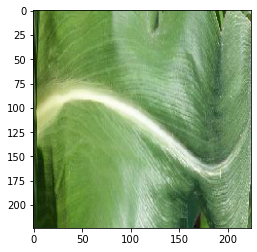

In [7]:
#Test random data

import tensorflow
import numpy as np
import matplotlib.pyplot as plt

from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import load_model

classes = ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']

img_path = 'train/Corn_(maize)___healthy/09cc5ed5-8de6-4a45-9cc2-166363c5a1e2___R.S_HL 5558 copy.jpg'

new_model = load_model('saved_model/model')
new_model.load_weights('saved_weight')
img = image.load_img(img_path, target_size=(224, 224, 3))
plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
result = new_model.predict(x/255.)
print(result)
print(np.max(result))
print(np.argmax(result))
print(classes[np.argmax(result)])
# print(np.max(result))

In [1]:
! git init

Reinitialized existing Git repository in /home/jupyter/.git/


In [2]:
!ls

checkpoint		 saved_weight.data-00000-of-00001  tutorials
plant_detection.ipynb	 saved_weight.index		   val
Plant-Diseases-Detector  test.jpg			   vgg19.ipynb
PlantVillage-Dataset	 tflite_models
saved_model		 train


In [3]:
! git commit -m "first commit"


*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: empty ident name (for <jupyter@image-classification-gemastik123.us-central1-a.c.website-170301.internal>) not allowed


In [4]:
! git config --global user.email "hutapeasalomo@gmail.com"

In [5]:
! git config --global user.name "salomohutapea"

In [ ]:
! git rm -r -f --cached .

In [ ]:
!git add saved_model
!git add checkpoint
!git add plant_det